!pip3 install ipywidgets

# Fútbol bayesiano

Carga de librerías

In [193]:
import os
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from cmdstanpy import CmdStanModel

Se definen rutas relativas del archivo

In [42]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

Cargar en memoria archivo de configuración

In [43]:
with open(os.path.join(ROOT, 'config.yml'), 'r') as file_:
    config = yaml.safe_load(file_)
file_.close()

# 1. Análisis exploratorio de datos

## 1.1 Exploración tabular

Dimensiones básicas del conjunto de datos

In [44]:
# Lectura de datos en bruto
futbol_df = pd.read_csv(
    os.path.join(ROOT, config['datos']['raw'])
    ,encoding='latin-1'
)

# Generar catálogo de datos
info_ = os.path.join(ROOT, config['datos']['cat_raw'])

with open(file=info_, mode='w') as file_:
    futbol_df.info(buf=file_)
file_.close()

print(' Dims. Básicas '.center(35, '-'))
print('rows:'.ljust(10, ' ') + f'{futbol_df.shape[0]:_.0f}')
print('cols:'.ljust(10, ' ') + f'{futbol_df.shape[1]:_.0f}')

---------- Dims. Básicas ----------
rows:     23_921
cols:     44


Formatear los nombres de las columnas a *snake_case*

In [45]:
futbol_df.columns = [col_name.lower() for col_name in futbol_df.columns]

Se seleccionan únicamente los partidos registrados después del mundial del 2018 en adelante, esto es debido a que se utilizará este como periodo de entrenamiento para los modelos, para posteriormente hacer predicciones para el mundial de Qatar 2022

In [46]:
futbol_mask = (
    futbol_df
    .query('year > 2018')
    .filter(items=[
        'day'
        ,'month'
        ,'year'
        ,'tournament'
        ,'home_team'
        ,'away_team'
        ,'neutral_location'
        ,'home_team_score'
        ,'away_team_score'
        ,'home_team_fifa_rank'
        ,'away_team_fifa_rank'
        ,'home_team_continent'
        ,'away_team_continent'
        ,'validacion_confederacion'])
    .reset_index(drop=True)
)

print(' Dims. Básicas '.center(35, '-'))
print('rows:'.ljust(10, ' ') + f'{futbol_mask.shape[0]:_.0f}')
print('cols:'.ljust(10, ' ') + f'{futbol_mask.shape[1]:_.0f}')

---------- Dims. Básicas ----------
rows:     3_021
cols:     14


## 1.2 Completitud de los datos

Al hacer un mapa de calor de los valores faltantes, se observa que la base está completa después de hacer el filtrado de datos por fecha.

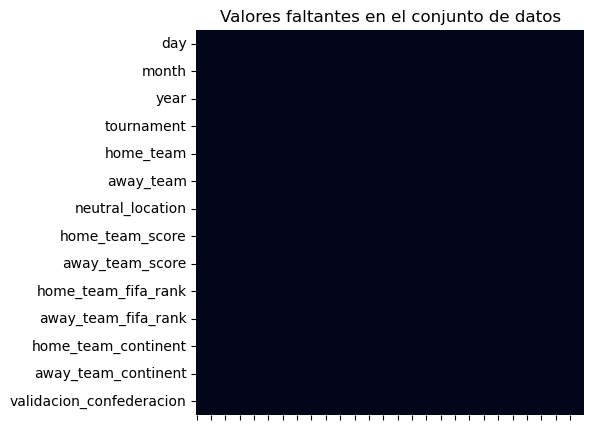

In [47]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(5,5))

# Elementos de figura
sns.heatmap(
    futbol_mask.isna().T
    ,cbar=False
    ,ax=ax)

# Anotaciones y estilo
ax.set_title('Valores faltantes en el conjunto de datos')
ax.set_xticklabels('')

plt.show()

## 1.2 Visualizaciones

Una primera visualización en la que se puede pensar es en el número de partidos que se jugaron en cada categoría de torneo

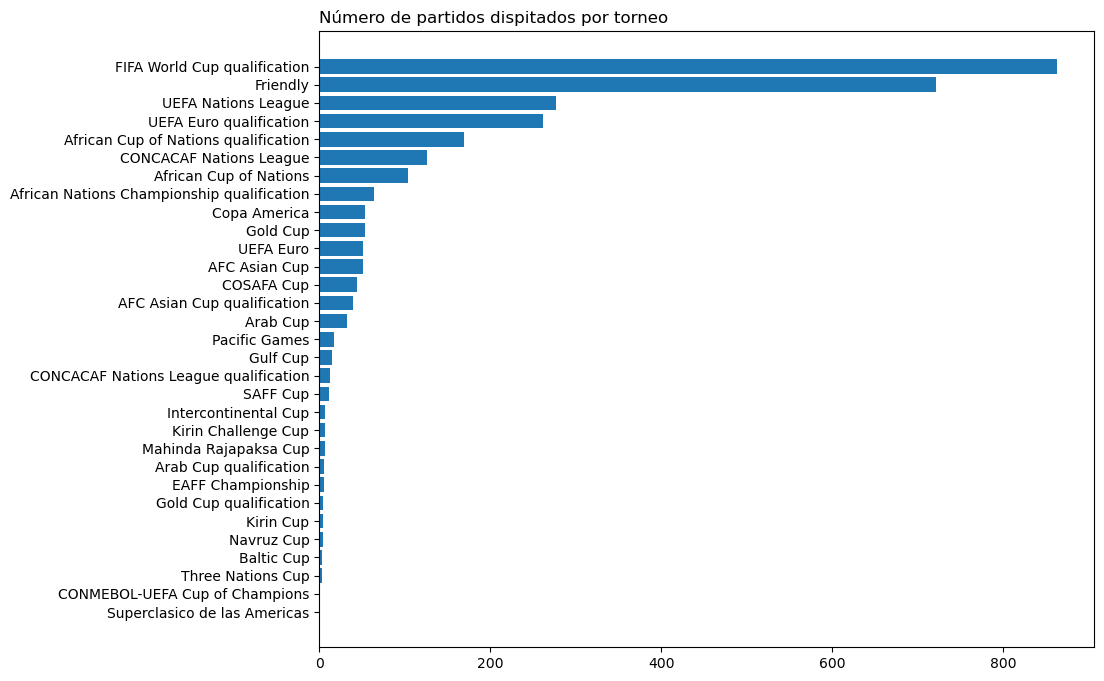

In [48]:
# Datos de la visualización
df_ = (
    futbol_mask
    .filter(items=['tournament', 'day'])
    .groupby(by='tournament')
    .count()
    .sort_values(by='day', ascending=True)
)
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10,8))

# Elementos de figura
ax.barh(
    y=df_.index
    ,width=df_.day
)
# Anotaciones y estilo
ax.set_title('Número de partidos dispitados por torneo', loc='left')

plt.show()

Otra visualización en la que se puede pensar es en la proporción de partidos que se disputaron en territorios neutrales. En una sección posterior, se modela la localía como un factor importante en la definición de un partido.

In [49]:
# Datos de visualización
(
    futbol_mask
    .filter(items=['neutral_location','day'])
    .groupby(by='neutral_location')
    .count()
    .assign(
        pct_partidos = lambda df_: df_.day / df_.day.sum()
    )
)

,day,pct_partidos
neutral_location,,
False,2197,0.727243
True,824,0.272757


Adicionalmente, se puede determinar el porcentaje de juegos en territorio neutral por torneo disputado.

In [50]:
(
    futbol_mask
    .filter(items=['tournament','neutral_location','day'])
    .pivot_table(
        values='day'
        ,index='tournament'
        ,columns='neutral_location'
        ,aggfunc='count')
    .fillna(value=0)
    .sort_values(by=True, ascending=False)
)

neutral_location,False,True
tournament,,
Friendly,495.0,226.0
FIFA World Cup qualification,716.0,147.0
African Cup of Nations,11.0,93.0
AFC Asian Cup,6.0,45.0
Copa America,13.0,41.0
Gold Cup,12.0,41.0
COSAFA Cup,9.0,35.0
African Cup of Nations qualification,139.0,30.0
Arab Cup,6.0,26.0


También es posible determinar el número de partidos disputados entre equipos de la misma región geográfica. Esto es importante debido a que define una posible jerarquía, que de cierto modo debería ser capturada por la confederación de cada equipo, pero se decide hacerla explícita utilizando la región debido a la segregación presente en los diferentes torneos.

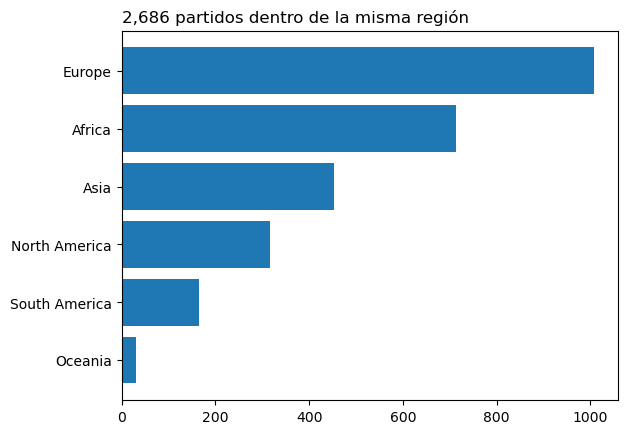

In [51]:
# Datos de visualización
df_ = (
    futbol_mask
    .query(expr='validacion_confederacion == 1')
    .filter(items=['home_team_continent','day'])
    .groupby(by='home_team_continent')
    .count()
    .sort_values(by='day', ascending=True))

# Especificaciones de figura
fig, ax = plt.subplots()

# Elementos de figura
ax.barh(
    y=df_.index
    ,width=df_.day)

# Anotaciones y estilo
val_ = df_.day.sum()
ax.set_title(f'{val_:,} partidos dentro de la misma región', loc='left')

plt.show()

Habiendo hecho la separación anterior, se puede hacer el mismo ejercicio para los partidos disputados entre equipos de diferentes regiones. Estos se pueden agrupar en una categoría adicional al mismo nivel de la región que, por fines prácticos, se llamará `Mundial`.

Esto es importante para darle al modelo la capacidad de extraer información de partidos disputados entre equipos de diferentes regiones.

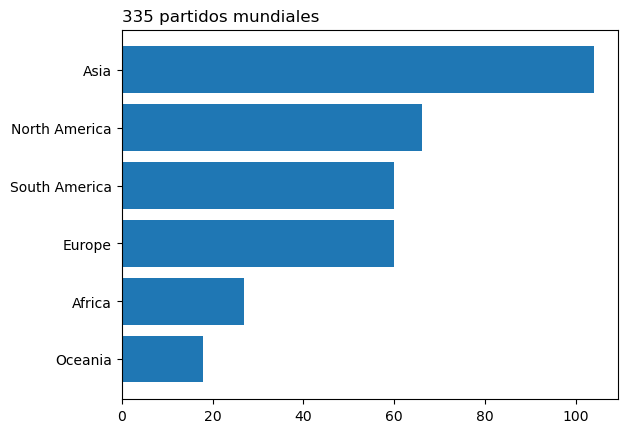

In [52]:
# Datos de visualización
df_ = (
    futbol_mask
    .query(expr='validacion_confederacion == 0')
    .filter(items=['home_team_continent','day'])
    .groupby(by='home_team_continent')
    .count()
    .sort_values(by='day', ascending=True))

# Especificaciones de figura
fig, ax = plt.subplots()

# Elementos de figura
ax.barh(
    y=df_.index
    ,width=df_.day)

# Anotaciones y estilo
val_ = df_.day.sum()
ax.set_title(f'{val_:,} partidos mundiales', loc='left')

plt.show()

# 2. Modelado

Se puede pensar que los equipos que participan en los distintos torneos que se organizan mundialmente, tienen determinado poder ofensivo y poder defensivo que en determinada medida está regido por la región en la que jueguen. Dicho de otra manera, no tienen la misma capacidad al ataque o defensa un equipo campeón en Norte América comparado con un equipo campeón en Europa. Para modelarlo, se puede estructurar el problema de modo que se haga inferencia sobre los goles que un equipo puede anotar en la disputa de un juego.

Para ser consistentes con el proceso de inferencia Bayesiana, el modelo se irá construyendo de manera incremental, incorporando poco a poco información relevante para explicar los partidos.

Se empieza extrayendo información relevante para el modelado:

## 2.1 Preproceso de datos

Primero se importa la función `sign` de la librería `numpy`, que sirve para extraer la señal de un número:

* $f(x)=-1$ si $x<0$
* $f(x)=0$ si $x=0$
* $f(x)=1$ si $x>0$


Ahora se hace la transformación de datos pertinenete para el modelado del problema:

In [167]:
df_ = (
    # Conjunto base de datos
    futbol_mask
    # Filtrado de columnas
    .filter(items=[
        'home_team'
        ,'away_team'
        ,'home_team_score'
        ,'away_team_score'
    ])
    # Formato de columnas categóricas
    .assign(
        home_team = lambda df_: pd.Categorical(df_.home_team)
        ,away_team = lambda df_: pd.Categorical(df_.away_team)
    )
    # Columnas calculadas
    .assign(
        # -1: Away win, 0: Draw, 1: Home win
        match_result = lambda df_:
            (df_.home_team_score - df_.away_team_score).apply(np.sign)
    )
)

df_

,home_team,away_team,home_team_score,away_team_score,match_result
0,Oman,Thailand,2,0,1
1,United Arab Emirates,Bahrain,1,1,0
2,Thailand,India,1,4,-1
3,Australia,Jordan,0,1,-1
4,Syria,Palestine,0,0,0
...,...,...,...,...,...
3016,Moldova,Andorra,2,1,1
3017,Liechtenstein,Latvia,0,2,-1
3018,Chile,Ghana,0,0,0
3019,Japan,Tunisia,0,3,-1


## 2.2 Distribución de goles

Una vez realizado el procesamiento anterior, es posible mapear la distribución de goles bajo el supuesto de que todos los equipos tienen la misma probabilidad de marcar un tanto en el momento en el que se les presenta la oportunidad.

Dado este supuesto, la distribución del número de goles marcados por equipo se puede capturar con una distribusión Poisson, cuyo parámetro $\lambda$ puede obtenerse con el promedio de los goles anotados por todos los equipos de los datos, es decir:

$$\lambda = \frac{1}{N}\sum_{i=1}^n g_i;\,\,\,\,\,g_i\in G^H\cup G^A$$

Siendo:

* $g_i$: El i-ésimo número de goles en el conjunto de local ($G^H$) y visitante ($G^A$)

In [168]:
from scipy.stats import poisson

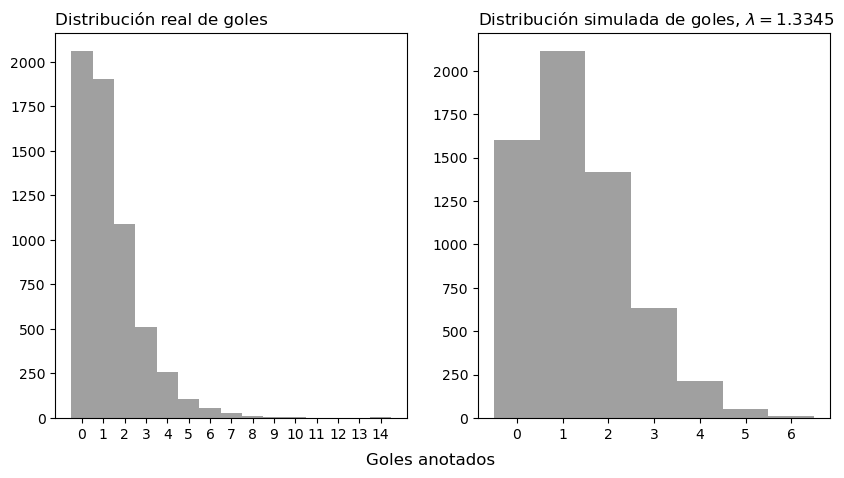

In [169]:
# Datos de la visualización
vis_ = pd.DataFrame(
    {'real': pd.concat((df_.home_team_score, df_.away_team_score))}
)
# Goles simulados
vis_['sims'] = poisson.rvs(
    mu=vis_.real.mean()
    ,loc=0
    ,size=vis_.shape[0])

# Especificaciones de figura
fig = plt.figure(figsize=(10,5))
gs = plt.GridSpec(nrows=1, ncols=2, figure=fig, wspace=0.2, hspace=0.2)

# Visualizaciones
ax1 = fig.add_subplot(gs[0])
ax1.hist(
    x=vis_.real
    ,bins=vis_.real.max()
    ,align='left'
    ,color='grey'
    ,alpha=0.75)

ax2 = fig.add_subplot(gs[1])
ax2.hist(
    x=vis_.sims
    ,bins=vis_.sims.max()
    ,align='left'
    ,color='grey'
    ,alpha=0.75)

# Anotaciones y estilo
ax1.set_title('Distribución real de goles', loc='left')
ax1.set_xticks(np.arange(vis_.real.min(),vis_.real.max(),1))

ax2.set_title(f'Distribución simulada de goles, $\lambda=${vis_.real.mean():.4f}', loc='left')
ax2.set_xticks(np.arange(vis_.sims.min(),vis_.sims.max(),1))
fig.supxlabel('Goles anotados')

plt.show()

Al observar el panel anterior, podemos ver que el número de goles simulados tal vez sería mucho más consistente con lo que podría esperar un experto del fútbol. Se ve en la distribución real, que hubo partidos en los que algún equipo llegó a anotar hasta 14 tantos, pero esto es algo sumamente improbable en un partido profesional.

¿Pero qué no todos los equipos de selección son equipos profesionales? La respuesta es un contundente sí, sin embargo, no todos los profesionales tienen la misma habilidad. Habrá algunas selecciones que estén al nivel de un equipo amateur en algunas regiones, y es precisamente esto lo que se irá explorando en el desarrollo del modelo.

## 2.3 Incorporando habilidad

El resultado de un partido se ve influido por la habilidad de cada equipo que lo disputa, eso es indiscutible. En términos de goles anotados, el número de tantos que un equipo anota se ve beneficiado por su habilidad ($skill_i$), pero se ve perjudicado por la habilidad del rival ($skill_j$).

$$G^H_{i,j}\sim Poisson(\lambda^H_{i,j})$$
$$G^A{i,j}\sim Poisson(\lambda^A_{i,j})$$
$$log(\lambda^H_{i,j})=baseline + skill_i - skill_j$$
$$log(\lambda^A_{i,j})=baseline + skill_j - skill_i$$

En donde $baseline$ es el número de goles que un equipo anotaría cuando se enfrenta a otro equipo igualmente bueno.

Para un primer modelo, y dado que se tiene un conjunto de datos relativamente grande, se pueden utilizar distribuciones iniciales no informativas que después se pueden sujetar a un proceso de calibración. De momento, considerar que:

$$baseline\sim N(0, 4^2)$$
$$skill_{1...n}\sim N(\mu_{teams}, \sigma^2_{teams})$$
$$\mu_{teams}\sim N(0,4^2)$$
$$\sigma_{teams}\sim U(0,3)$$

## 2.3.1 Implementación en STAN

Primero se definen algunas funciones útiles para la creación y manipulación de archivos de `stan`, y se crea un proyecto nuevo para la primera iteración del modelo jerárquico.

In [170]:
import BFG3000 as bfg

In [176]:
name = 'iter2_jera'
sp_ = bfg.StanProject(name)
dir_, model_ = sp_.create_stan_project(dir='modelos')

Ya existe un proyecto con el nombre iter2_jera


Una vez creado y editado el proyecto de STAN, se declara el siguiente bloque de código para mantener estructura en la compilación del modelo y los archivos que éste genera.

In [172]:
# Compilar el modelo
compile_ = CmdStanModel(
    model_name=name
    ,stan_file=model_
    ,compile=True)

Se delcara un diccionario de datos para proporcionar los datos a stan

In [173]:
stan_data_ = {
    'n_matches': df_.shape[0]
    ,'goals_home': df_.home_team_score.values
    ,'goals_away': df_.away_team_score.values
}

Finalmente, se ejecuta el modelo y se calibra. Este paso es recursivo y se tiene que ejecutar tantas veces sean necesarias de modo que las cadenas generadas por el muestreador tengan diagnósticos buenos.

In [174]:
fit_ = compile_.sample(
    data=stan_data_
    ,chains=4
    ,iter_warmup=1_250
    ,iter_sampling=5000
    ,show_progress=True
    ,save_warmup=False
)

21:46:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:54:30 - cmdstanpy - INFO - CmdStan done processing.
21:54:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is -0.759836, but must be positive! (in '/Users/eduardo/Documents/Maestría/Bayesiana/futbol_bayes/modelos/iter2_jera/iter2_jera.stan', line 35, column 4 to column 47)
	Exception: normal_lpdf: Scale parameter is -0.392458, but must be positive! (in '/Users/eduardo/Documents/Maestría/Bayesiana/futbol_bayes/modelos/iter2_jera/iter2_jera.stan', line 35, column 4 to column 47)
	Exception: normal_lpdf: Scale parameter is -1.95639, but must be positive! (in '/Users/eduardo/Documents/Maestría/Bayesiana/futbol_bayes/modelos/iter2_jera/iter2_jera.stan', line 35, column 4 to column 47)
	Exception: normal_lpdf: Scale parameter is -0.137063, but must be positive! (in '/Users/eduardo/Documents/Maestría/Bayesiana/futbol_bayes/modelos/iter2_jera/iter2_jera.stan', line 35, column 4 to column 47)
	Exception: normal_lpdf: Scale parameter is -

In [195]:
fit_path = os.path.join(dir_,name+"_fit.pkl")

with open(fit_path,'wb') as f:
    pickle.dump(fit_, f)


#with open('model.pkl', 'rb') as f:
#    model = pickle.load(f)

## 2.3.2 Diagnóstico de convergencia

Resume de estimadores

In [175]:
summary_ = fit_.summary()
summary_

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-2778.110000,6.432290,191.940000,-3088.340000,-2779.450000,-2459.770000,890.433,0.895958,1.004340
baseline[1],-0.475335,0.005487,0.809109,-1.934830,-0.386374,0.698915,21747.700,21.882700,0.999891
baseline[2],-0.365163,0.005661,0.788915,-1.792250,-0.282883,0.765828,19418.900,19.539400,0.999833
baseline[3],0.623035,0.003471,0.514853,-0.292136,0.664728,1.389640,21999.200,22.135700,0.999845
baseline[4],-1.281860,0.009063,1.135200,-3.380200,-1.124920,0.285536,15688.100,15.785500,1.000190
...,...,...,...,...,...,...,...,...,...
sims_away[3017],1.225200,0.009545,1.472720,0.000000,1.000000,4.000000,23807.700,23.955400,0.999963
sims_away[3018],1.461300,0.010635,1.647560,0.000000,1.000000,5.000000,24000.500,24.149400,0.999951
sims_away[3019],0.122350,0.003035,0.430685,0.000000,0.000000,1.000000,20138.800,20.263800,0.999900
sims_away[3020],2.299400,0.013535,2.098400,0.000000,2.000000,6.000000,24036.100,24.185200,0.999908


In [179]:
summary_.to_csv(os.path.join(dir_,name+".csv"))



In [180]:
summary_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)

Visualización del error estándar MC de los parámetros simples

In [181]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param','MCSE'])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)[1:]


,param,MCSE
9064,mu_teams,0.70863
9065,sigma_teams,0.00057


Visualización del error estándar MC de los parámetros múltiples

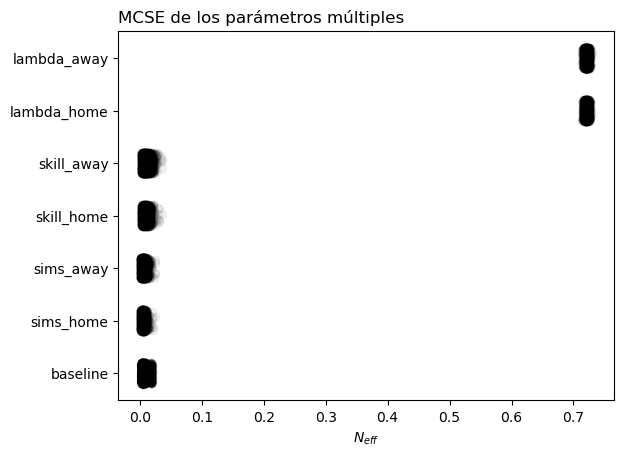

In [182]:
# Datos de visualización
diagnostico = 'MCSE'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param',diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='black'
    ,alpha=0.05)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(r'$N_{eff}$')
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    , labels=vis_.param.cat.categories)

plt.show()

Número efectivo de simulaciones de los parámetros simples

In [183]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param','N_Eff'])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)


,param,N_Eff
0,lp__,890.43300
9064,mu_teams,2.17251
9065,sigma_teams,959.67927


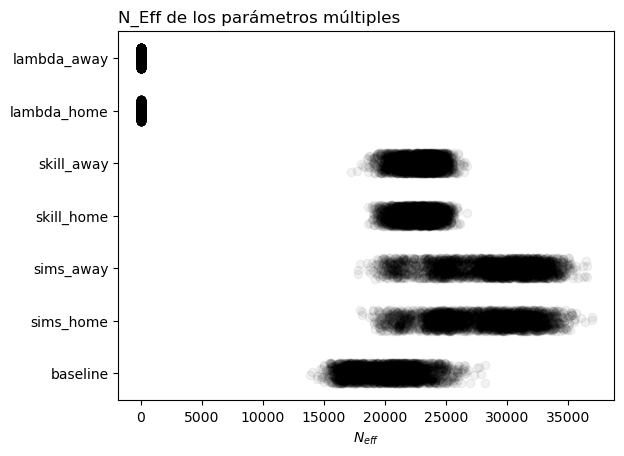

In [184]:
# Datos de visualización
diagnostico = 'N_Eff'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param',diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='black'
    ,alpha=0.05)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(r'$N_{eff}$')
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    , labels=vis_.param.cat.categories)

plt.show()

Traza de las cadenas

In [185]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=False)
chains_.shape

(5000, 4, 21156)

In [190]:
chains_txt= os.path.join(dir_,name+"_chain.npy")
np.save(chains_txt,chains_)

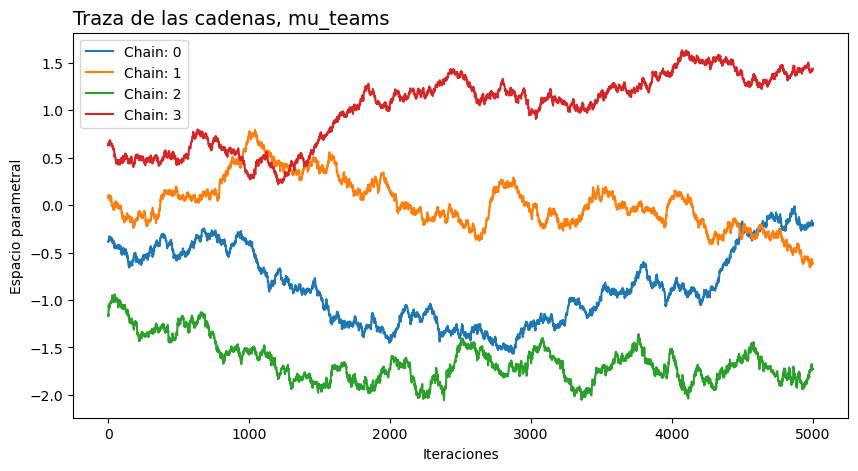

In [191]:
# Datos de la visualización
param_ = 'mu_teams'
idp_ = fit_.column_names.index(param_)
arr_ = chains_[:, :, idp_]

# Especificaciones de figura
plt.figure(figsize=(10,5))

# Visualizaciones
for chain in range(arr_.shape[1]):
    plt.plot(arr_[:, chain], label=f'Chain: {chain}')

# Anotaciones y estilo
plt.title(f'Traza de las cadenas, {param_}', loc='left', fontsize=14)
plt.xlabel('Iteraciones')
plt.ylabel('Espacio parametral')
plt.legend()

plt.show()

Convergencia de cadenas

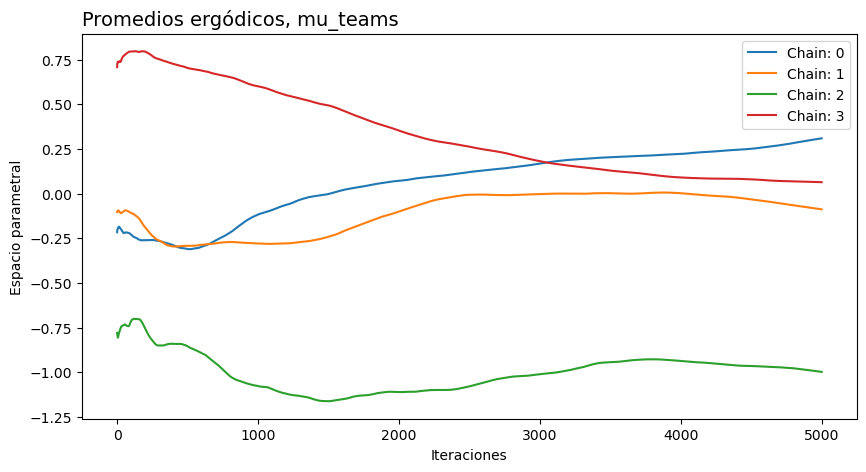

In [69]:
# Datos de la visualización
ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

# Especificaciones de figura
plt.figure(figsize=(10,5))

# Visualizaciones
for chain in range(ergo_.shape[1]):
    plt.plot(ergo_[:, chain], label=f'Chain: {chain}')

# Anotaciones y estilo
plt.title(f'Promedios ergódicos, {param_}', loc='left', fontsize=14)
plt.xlabel('Iteraciones')
plt.ylabel('Espacio parametral')
plt.legend()

plt.show()

## 2.3.3 Simulaciones

In [70]:
stan_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)
stan_vis_.param.value_counts()

param
baseline       3021
skill_home     3021
skill_away     3021
lambda_home    3021
lambda_away    3021
sims_home      3021
sims_away      3021
lp__              1
mu_teams          1
sigma_teams       1
Name: count, dtype: int64

In [71]:
countries = ['Ecuador', 'Mexico', 'Argentina', 'Germany']

for country in countries:
    res_ = (
        stan_vis_
        .loc[stan_vis_.param == 'skill_home']
        .reset_index(drop=True)
        .loc[(# Índices de juegos en los que México fue local
            df_
            .loc[df_.home_team == country]
            .index
            .to_numpy()
        )]
    )

    print(f"{country}, Home skill: {res_.Mean.mean():.4f}")

Ecuador, Home skill: -0.0901
Mexico, Home skill: -0.0557
Argentina, Home skill: -0.0422
Germany, Home skill: -0.0270


In [72]:
preds = {
    'preds_home':(
        stan_vis_
        .loc[stan_vis_.param == 'sims_home']
        .Mean
        .apply(int)).values
    ,'preds_away':(
    stan_vis_
    .loc[stan_vis_.param == 'sims_away']
    .Mean
    .apply(int)).values
}

preds = (
    pd.DataFrame(preds)
    .assign(
        # -1: Away win, 0: Draw, 1: Home win
        match_result = lambda df_:
            (df_.preds_home - df_.preds_away).apply(np.sign)
    )
)
preds

,preds_home,preds_away,match_result
0,1,0,1
1,1,1,0
2,1,3,-1
3,0,0,0
4,0,0,0
...,...,...,...
3016,1,1,0
3017,0,1,-1
3018,0,0,0
3019,0,2,-1


In [73]:
# Accuracy de ganador
sum(preds.match_result == df_.match_result) / df_.shape[0]

0.6173452499172459

In [74]:
# Accuracy goals_home
sum(preds.preds_home == df_.home_team_score) / df_.shape[0]

0.46640185369083087

In [75]:
# Accuracy goals away
sum(preds.preds_away == df_.away_team_score) / df_.shape[0]

0.6550810989738497

## 3 Modelo no agrupado

In [196]:
df_ = (
    # Conjunto base de datos
    futbol_mask
    # Filtrado de columnas
    .filter(items=[
        'home_team'
        ,'away_team'
        ,'home_team_score'
        ,'away_team_score'
        ,'home_team_continent'
        ,'away_team_continent'
    ])
    # Formato de columnas categóricas
    .assign(
        home_team = lambda df_: pd.Categorical(df_.home_team)
        ,away_team = lambda df_: pd.Categorical(df_.away_team)
        ,home_team_continent = lambda df_: pd.Categorical(df_.home_team_continent)
        ,away_team_continent = lambda df_: pd.Categorical(df_.away_team_continent)
    )
    # Columnas calculadas
    .assign(
        # -1: Away win, 0: Draw, 1: Home win
        match_result = lambda df_:
            (df_.home_team_score - df_.away_team_score).apply(np.sign)
    )
)

df_

,home_team,away_team,home_team_score,away_team_score,home_team_continent,away_team_continent,match_result
0,Oman,Thailand,2,0,Asia,Asia,1
1,United Arab Emirates,Bahrain,1,1,Asia,Asia,0
2,Thailand,India,1,4,Asia,Asia,-1
3,Australia,Jordan,0,1,Oceania,Asia,-1
4,Syria,Palestine,0,0,Asia,Asia,0
...,...,...,...,...,...,...,...
3016,Moldova,Andorra,2,1,Europe,Europe,1
3017,Liechtenstein,Latvia,0,2,Europe,Europe,-1
3018,Chile,Ghana,0,0,South America,Africa,0
3019,Japan,Tunisia,0,3,Asia,Africa,-1


Al observar el panel anterior, podemos ver que el número de goles simulados tal vez sería mucho más consistente con lo que podría esperar un experto del fútbol. Se ve en la distribución real, que hubo partidos en los que algún equipo llegó a anotar hasta 14 tantos, pero esto es algo sumamente improbable en un partido profesional.

¿Pero qué no todos los equipos de selección son equipos profesionales? La respuesta es un contundente sí, sin embargo, no todos los profesionales tienen la misma habilidad. Habrá algunas selecciones que estén al nivel de un equipo amateur en algunas regiones, y es precisamente esto lo que se irá explorando en el desarrollo del modelo.

## 3.3 Incorporando habilidad

El resultado de un partido se ve influido por la habilidad de cada equipo que lo disputa, eso es indiscutible. En términos de goles anotados, el número de tantos que un equipo anota se ve beneficiado por su habilidad ($skill_i$), pero se ve perjudicado por la habilidad del rival ($skill_j$).

$$G^H_{i,j}\sim Poisson(\lambda^H_{i,j})$$
$$G^A{i,j}\sim Poisson(\lambda^A_{i,j})$$
$$log(\lambda^H_{i,j})=baseline_{[j]} + skill_i - skill_j$$
$$log(\lambda^A_{i,j})=baseline_{[j]} + skill_j - skill_i$$

En donde $baseline$ es el número de goles que un equipo anotaría cuando se enfrenta a otro equipo igualmente bueno.

Para un primer modelo, y dado que se tiene un conjunto de datos relativamente grande, se pueden utilizar distribuciones iniciales no informativas que después se pueden sujetar a un proceso de calibración. De momento, considerar que:

$$baseline\sim N(\mu_{bl}, \sigma_{bl})$$
$$skill_{1...n}\sim N(\mu_{teams}, \sigma_{teams})$$
$$\mu_{teams}\sim N(0,4)$$
$$\sigma_{teams}\sim Ga(5,5)$$
$$\mu_{bl}\sim N(0,4)$$
$$\sigma_{bl}\sim Ga(5,5)$$

## 2.3.1 Implementación en STAN

Primero se definen algunas funciones útiles para la creación y manipulación de archivos de `stan`, y se crea un proyecto nuevo para la primera iteración del modelo jerárquico.

In [197]:
name = 'iter3_no_ag'
sp_ = bfg.StanProject(name)
dir_, model_ = sp_.create_stan_project(dir='modelos')

Ya existe un proyecto con el nombre iter3_no_ag


Una vez creado y editado el proyecto de STAN, se declara el siguiente bloque de código para mantener estructura en la compilación del modelo y los archivos que éste genera.

In [198]:
# Compilar el modelo
compile_ = CmdStanModel(
    model_name=name
    ,stan_file=model_
    ,compile=True)

Se delcara un diccionario de datos para proporcionar los datos a stan

In [199]:
stan_data_ = {
    'n_matches': df_.shape[0]
    ,'n_regiones': len(df_.home_team_continent.cat.categories)
    ,'goals_home': df_.home_team_score.values
    ,'goals_away': df_.away_team_score.values
    ,'regiones': np.sort(df_.home_team_continent.cat.codes.unique())+1
}
stan_data_

{'n_matches': 3021,
 'n_regiones': 6,
 'goals_home': array([2, 1, 1, ..., 0, 0, 4]),
 'goals_away': array([0, 1, 4, ..., 0, 3, 1]),
 'regiones': array([1, 2, 3, 4, 5, 6], dtype=int8)}

Finalmente, se ejecuta el modelo y se calibra. Este paso es recursivo y se tiene que ejecutar tantas veces sean necesarias de modo que las cadenas generadas por el muestreador tengan diagnósticos buenos.

In [200]:
fit_ = compile_.sample(
    data=stan_data_
    ,chains=4
    ,iter_warmup=100
    ,iter_sampling=500
    ,show_progress=True
    ,save_warmup=False
)

22:18:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [ ]:
fit_path = os.path.join(dir_,name+"_fit.pkl")

with open(fit_path,'wb') as f:
    pickle.dump(fit_, f)


#with open('model.pkl', 'rb') as f:
#    model = pickle.load(f)

## 2.3.2 Diagnóstico de convergencia

Resume de estimadores

In [139]:
summary_ = fit_.summary()
summary_

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-2887.900000,20.584800,185.906000,-3192.550000,-2887.780000,-2580.56000,81.56330,0.022257,1.062000
mu_bl,-0.114167,0.196611,3.783480,-6.507710,-0.034341,6.05148,370.31200,0.101051,1.007420
sigma_bl,0.988494,0.013217,0.437983,0.406204,0.923080,1.83528,1098.15000,0.299663,1.001950
"baseline[1,1]",-52.519400,23.007700,43.724900,-121.003000,-44.860600,26.32890,3.61170,0.000986,2.055520
"baseline[1,2]",-20.537700,34.472100,55.459600,-115.262000,-20.184900,72.11860,2.58833,0.000706,3.313550
...,...,...,...,...,...,...,...,...,...
sims_away[3017],1.199000,0.032951,1.511470,0.000000,1.000000,4.00000,2104.14000,0.574177,1.001730
sims_away[3018],1.486500,0.035306,1.658670,0.000000,1.000000,5.00000,2207.10000,0.602272,0.998651
sims_away[3019],0.008000,0.004685,0.148145,0.000000,0.000000,0.00000,1000.00000,0.272879,1.000920
sims_away[3020],2.380500,0.048685,2.180390,0.000000,2.000000,7.00000,2005.78000,0.547335,0.999580


In [ ]:
summary_.to_csv(os.path.join(dir_,name+".csv"))



In [140]:
summary_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)

Visualización del error estándar MC de los parámetros simples

In [141]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param','MCSE'])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)[1:]


,param,MCSE
1,mu_bl,0.196611
2,sigma_bl,0.013217
24171,mu_teams,0.299880
24172,sigma_teams,0.002000


Visualización del error estándar MC de los parámetros múltiples

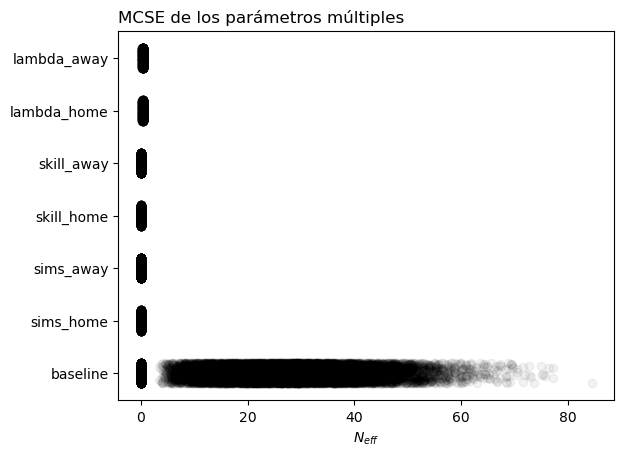

In [142]:
# Datos de visualización
diagnostico = 'MCSE'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param',diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='black'
    ,alpha=0.05)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(r'$N_{eff}$')
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    , labels=vis_.param.cat.categories)

plt.show()

Número efectivo de simulaciones de los parámetros simples

In [143]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param','N_Eff'])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)


,param,N_Eff
0,lp__,81.56330
1,mu_bl,370.31200
2,sigma_bl,1098.15000
24171,mu_teams,2.93471
24172,sigma_teams,83.67235


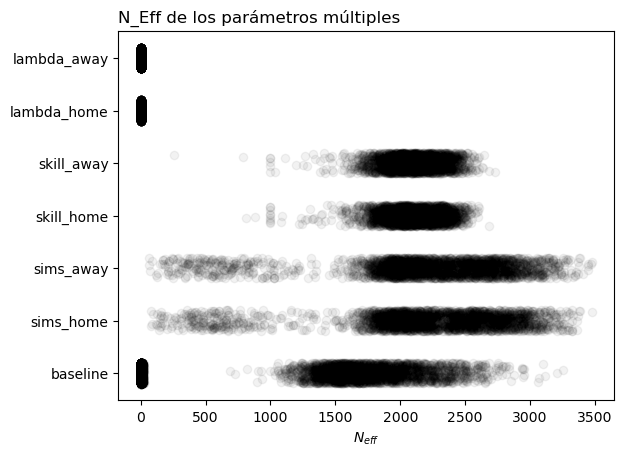

In [144]:
# Datos de visualización
diagnostico = 'N_Eff'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param',diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='black'
    ,alpha=0.05)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(r'$N_{eff}$')
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    , labels=vis_.param.cat.categories)

plt.show()

Traza de las cadenas

In [145]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=False)
chains_.shape

(500, 4, 36263)

In [ ]:
chains_txt= os.path.join(dir_,name+"_chain.npy")
np.save(chains_txt,chains_)

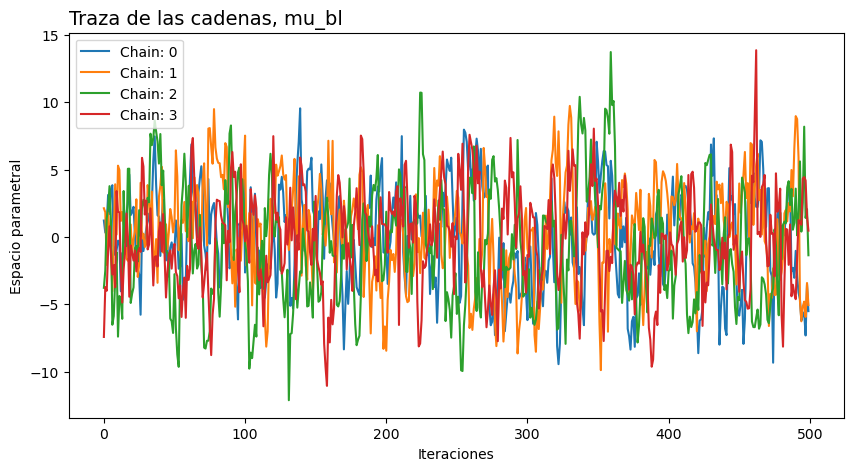

In [147]:
# Datos de la visualización
param_ = 'mu_bl'
idp_ = fit_.column_names.index(param_)
arr_ = chains_[:, :, idp_]

# Especificaciones de figura
plt.figure(figsize=(10,5))

# Visualizaciones
for chain in range(arr_.shape[1]):
    plt.plot(arr_[:, chain], label=f'Chain: {chain}')

# Anotaciones y estilo
plt.title(f'Traza de las cadenas, {param_}', loc='left', fontsize=14)
plt.xlabel('Iteraciones')
plt.ylabel('Espacio parametral')
plt.legend()

plt.show()

Convergencia de cadenas

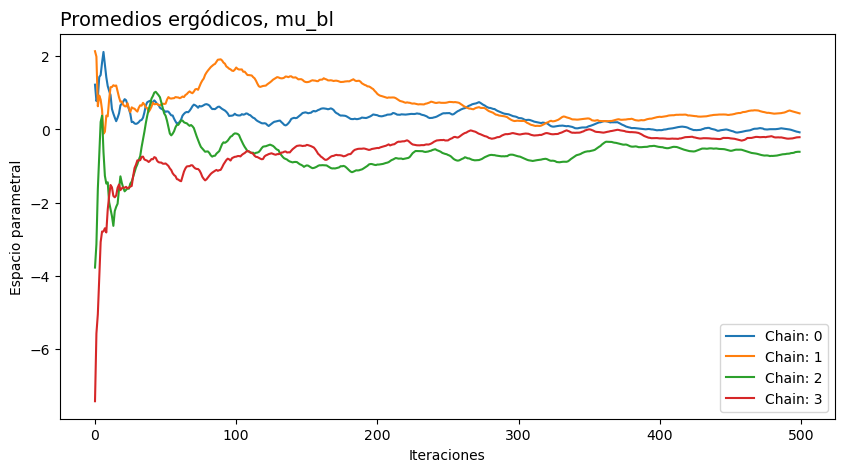

In [148]:
# Datos de la visualización
ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

# Especificaciones de figura
plt.figure(figsize=(10,5))

# Visualizaciones
for chain in range(ergo_.shape[1]):
    plt.plot(ergo_[:, chain], label=f'Chain: {chain}')

# Anotaciones y estilo
plt.title(f'Promedios ergódicos, {param_}', loc='left', fontsize=14)
plt.xlabel('Iteraciones')
plt.ylabel('Espacio parametral')
plt.legend()

plt.show()

## 2.3.3 Simulaciones

In [149]:
stan_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)
stan_vis_.param.value_counts()

param
baseline       18126
skill_home      3021
skill_away      3021
lambda_home     3021
lambda_away     3021
sims_home       3021
sims_away       3021
lp__               1
mu_bl              1
sigma_bl           1
mu_teams           1
sigma_teams        1
Name: count, dtype: int64

In [150]:
countries = ['Ecuador', 'Mexico', 'Argentina', 'Germany']

for country in countries:
    res_ = (
        stan_vis_
        .loc[stan_vis_.param == 'skill_home']
        .reset_index(drop=True)
        .loc[(# Índices de juegos en los que México fue local
            df_
            .loc[df_.home_team == country]
            .index
            .to_numpy()
        )]
    )

    print(f"{country}, Home skill: {res_.Mean.mean():.4f}")

Ecuador, Home skill: -0.6880
Mexico, Home skill: -0.6541
Argentina, Home skill: -0.6412
Germany, Home skill: -0.6275


In [151]:
preds = {
    'preds_home':(
        stan_vis_
        .loc[stan_vis_.param == 'sims_home']
        .Mean
        .apply(int)).values
    ,'preds_away':(
    stan_vis_
    .loc[stan_vis_.param == 'sims_away']
    .Mean
    .apply(int)).values
}

preds = (
    pd.DataFrame(preds)
    .assign(
        # -1: Away win, 0: Draw, 1: Home win
        match_result = lambda df_:
            (df_.preds_home - df_.preds_away).apply(np.sign)
    )
)
preds

,preds_home,preds_away,match_result
0,1,0,1
1,1,0,1
2,1,3,-1
3,0,0,0
4,0,0,0
...,...,...,...
3016,1,1,0
3017,0,1,-1
3018,0,0,0
3019,0,2,-1


In [152]:
# Accuracy de ganador
sum(preds.match_result == df_.match_result) / df_.shape[0]

0.5673618007282357

In [153]:
# Accuracy goals_home
sum(preds.preds_home == df_.home_team_score) / df_.shape[0]

0.4428997020854022

In [154]:
# Accuracy goals away
sum(preds.preds_away == df_.away_team_score) / df_.shape[0]

0.6285998013902682